In [1]:
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random

# linguistic
import string
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize

# text feature extraction
from helper import TextFeatures, CoreNLPHelper
import importlib
importlib.reload(TextFeatures)
importlib.reload(CoreNLPHelper)
coreNLPfeatures = CoreNLPHelper.CoreNLPFeatures(core_nlp_server_url="http://localhost:9000")

# svm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

#setup
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', 100)



FOLDER_MEDIUM = os.path.join("..", "datasets", "almost_scientific_medium")
FOLDER_REPORTS = os.path.join("..", "datasets", "almost_scientific_reports")
FOLDER_ARXIV = os.path.join("..", "datasets", "scientific_arxiv")

FOLDER_TF_SCI = os.path.join("..", "..", "datasets", "tensorflow scientific papers")

# might need:
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/arthur/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /Users/arthur/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/arthur/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Data gathering

In [5]:
num_samples = 3000

sent_medium = pickle.load(open(os.path.join(FOLDER_MEDIUM, "sentences.pickle"), "rb"))
sent_arxiv = pickle.load(open(os.path.join(FOLDER_ARXIV, "sentences.pickle"), "rb"))

# selecting sentences
random.shuffle(sent_medium)
random.shuffle(sent_arxiv)
sent_medium = sent_medium[:num_samples]
sent_arxiv = sent_arxiv[:num_samples]

df_medium = pd.DataFrame(data=sent_medium, columns=["sentence"])
df_medium['scientific'] = 0
df_arxiv = pd.DataFrame(data=sent_arxiv, columns=["sentence"])
df_arxiv['scientific'] = 1

df = pd.concat([df_medium, df_arxiv], ignore_index=True)
print(f"df: {df.shape}")

df: (6000, 2)


# Feature extraction

In [6]:
def add_features(df):
    columns = {}

    print("lexical features character based")
    (cols_lexical_char, df_sub) = TextFeatures.extract_lexical_features_character_based(df["sentence"])
    df[cols_lexical_char] = df_sub[cols_lexical_char]
    columns["cols_lexical_char"] = cols_lexical_char

    print("lexical features word based")
    (cols_lexical_word, df_sub) = TextFeatures.extract_lexical_features_word_based(df["sentence"])
    df[cols_lexical_word] = df_sub[cols_lexical_word]
    columns["cols_lexical_word"] = cols_lexical_word
    
    print("lexical features vocabulary richness")
    (cols_vocab_rich, df_sub) = TextFeatures.extract_vocabulary_richness(df["sentence"])
    df[cols_vocab_rich] = df_sub[cols_vocab_rich]
    columns["cols_vocab_rich"] = cols_vocab_rich

    print("pos tags")
    (cols_pos_tag, df_sub) = TextFeatures.extract_pos_tags(df["sentence"], universal=False)
    df[cols_pos_tag] = df_sub[cols_pos_tag]
    columns["cols_pos_tag"] = cols_pos_tag

    print("passive sentence")
    (cols_passive, df_sub) = coreNLPfeatures.extract_passive_case(df["sentence"])
    df[cols_passive] = df_sub[cols_passive]
    columns["cols_passive"] = cols_passive
    
    return (df, columns)

In [7]:
(df, columns_v1) = add_features(df)

lexical features character based
lexical features word based


  0%|          | 0/6000 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/6000 [00:00<?, ?it/s]

In [8]:
df.shape

(6000, 61)

In [9]:
df.head(2)

,sentence,scientific,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive
0,Important questions to answer include:,0,38,0.868421,0.026316,0.000000,0.105263,0.026316,5,0.2,6.600000,1.000000,1.000000,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,"For regression algorithms, the three most popular metrics are MAE, MSE and the R²-score.",0,88,0.795455,0.090909,0.011364,0.147727,0.045455,14,0.5,5.142857,0.928571,0.857143,0.076923,0,0,0,0,2,0,1,0,1,1,2,0,0,1,1,0,0,0,0,2,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# SVM

## SVM 1: as it is (pure)

f1: 62%

training X: ['total_chars', 'freq_chars_alpha', 'freq_chars_upper', 'freq_chars_digit', 'freq_chars_space', 'freq_chars_special', 'total_words', 'freq_words_short', 'avg_word_length', 'freq_unique_words', 'vocab_richness_hapax_legomena', 'vocab_richness_hapax_dislegomena', '$', "''", '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', '#', 'is_passive']

training y: scientific



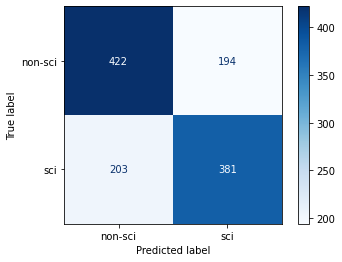

In [10]:
exclude_from_training = ["sentence", "scientific"]

X = df.drop(exclude_from_training, axis=1)
y = df['scientific']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
plot_confusion_matrix(clf_svm,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

print(f"training X: {list(X.columns)}\n")
print(f"training y: {y.name}\n")

In [11]:
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.68      0.69      0.68       616
         sci       0.66      0.65      0.66       584

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200



## SVM 2: Hyperparameter tuning

f1: 78%

In [12]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001)


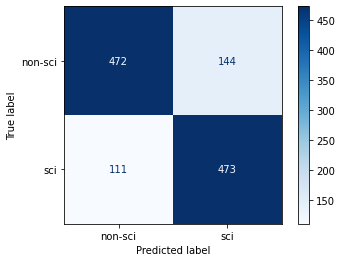

In [13]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
  
plot_confusion_matrix(grid,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [14]:
# print classification report
print(classification_report(y_test, grid_predictions, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.81      0.77      0.79       616
         sci       0.77      0.81      0.79       584

    accuracy                           0.79      1200
   macro avg       0.79      0.79      0.79      1200
weighted avg       0.79      0.79      0.79      1200



### Validation with student reports

In [15]:
sent_studentreports = pickle.load(open(os.path.join(FOLDER_REPORTS, "sentences.pickle"), "rb"))
print(f"Number of sentences: {len(sent_studentreports)}")

df_val = pd.DataFrame(data=sent_studentreports, columns=["sentence"])
(df_val, columns_val_student) = add_features(df_val)

Number of sentences: 4389
lexical features character based
lexical features word based


  0%|          | 0/4389 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/4389 [00:00<?, ?it/s]

  0%|          | 0/4389 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/4389 [00:00<?, ?it/s]

/Users/arthur/.pyenv/versions/3.9.4/envs/mrp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthur/.pyenv/versions/3.9.4/envs/mrp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthur/.pyenv/versions/3.9.4/envs/mrp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

     non-sci       1.00      0.40      0.57      4389
         sci       0.00      0.00      0.00         0

    accuracy                           0.40      4389
   macro avg       0.50      0.20      0.29      4389
weighted avg       1.00      0.40      0.57      4389



<AxesSubplot:>

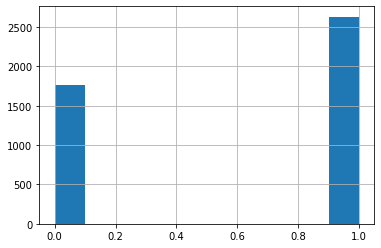

In [16]:
# to allow for repeated execution
try:
    val_pred = grid.predict(df_val.drop(["sentence", "pred_sci"], axis=1))
except KeyError as error:
    val_pred = grid.predict(df_val.drop(["sentence"], axis=1))

df_val['scientific'] = 0
df_val['pred_sci'] = val_pred

print(classification_report(df_val['scientific'],df_val['pred_sci'], target_names=["non-sci", "sci"]))

# Histogram to see results
df_val.pred_sci.hist()

Not really good. Majority is predicted to be of scientific style.

## SVM 3: New dataset -> latest tensorflow vs. medium

- f1: 75%
- f1 tuned: 85%

In [17]:
sent_tf_cleaned = pickle.load(open(os.path.join(FOLDER_TF_SCI, "filtered_sent_cola.pkl"), "rb"))

# selecting sentences
random.shuffle(sent_tf_cleaned)
sent_tf_cleaned = sent_tf_cleaned[:num_samples]

df_tf_cleaned = pd.DataFrame(data=sent_tf_cleaned, columns=["sentence"])
df_tf_cleaned['scientific'] = 1

df_v2 = pd.concat([df_medium, df_tf_cleaned], ignore_index=True)
print(f"df: {df_v2.shape}")

# add features
(df_v2, columns_v2) = add_features(df_v2)

df: (6000, 2)
lexical features character based
lexical features word based


  0%|          | 0/6000 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/6000 [00:00<?, ?it/s]

In [19]:
print(df_v2.shape)
df_v2.head(2)

(6000, 61)


,sentence,scientific,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive
0,Important questions to answer include:,0,38,0.868421,0.026316,0.000000,0.105263,0.026316,5,0.2,6.600000,1.000000,1.000000,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,"For regression algorithms, the three most popular metrics are MAE, MSE and the R²-score.",0,88,0.795455,0.090909,0.011364,0.147727,0.045455,14,0.5,5.142857,0.928571,0.857143,0.076923,0,0,0,0,2,0,1,0,1,1,2,0,0,1,1,0,0,0,0,2,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


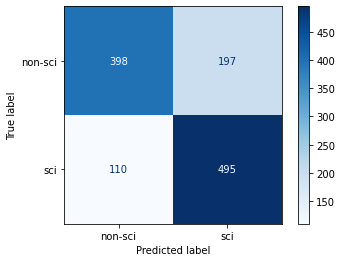

In [20]:
exclude_from_training = ["sentence", "scientific"]

X = df_v2.drop(exclude_from_training, axis=1)
y = df_v2['scientific']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
plot_confusion_matrix(clf_svm,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [21]:
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.78      0.67      0.72       595
         sci       0.72      0.82      0.76       605

    accuracy                           0.74      1200
   macro avg       0.75      0.74      0.74      1200
weighted avg       0.75      0.74      0.74      1200



### Hyperparameter tuning

In [22]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001)


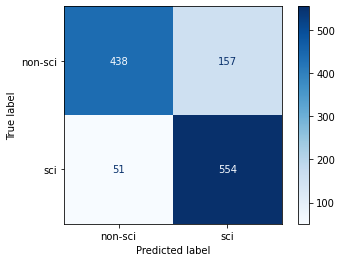

In [23]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
  
plot_confusion_matrix(grid,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [24]:
# print classification report
print(classification_report(y_test, grid_predictions, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.90      0.74      0.81       595
         sci       0.78      0.92      0.84       605

    accuracy                           0.83      1200
   macro avg       0.84      0.83      0.83      1200
weighted avg       0.84      0.83      0.83      1200



### Validation with student reports

In [25]:
# to allow for repeated execution
try:
    val_pred = grid.predict(df_val.drop(exclude_from_training + ["pred_sci"], axis=1))
except ValueError as error:
    val_pred = grid.predict(df_val.drop(["sentence"], axis=1))

df_val['scientific'] = 0
df_val['pred_sci'] = val_pred

print(classification_report(df_val['scientific'],df_val['pred_sci'], target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       1.00      0.60      0.75      4389
         sci       0.00      0.00      0.00         0

    accuracy                           0.60      4389
   macro avg       0.50      0.30      0.37      4389
weighted avg       1.00      0.60      0.75      4389



/Users/arthur/.pyenv/versions/3.9.4/envs/mrp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthur/.pyenv/versions/3.9.4/envs/mrp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arthur/.pyenv/versions/3.9.4/envs/mrp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

<AxesSubplot:>

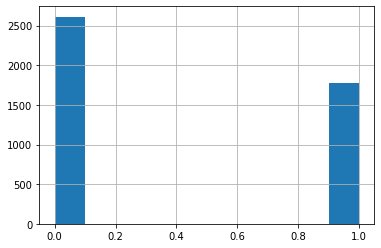

In [26]:
df_val.pred_sci.hist()

Looking much better with the distribution. Majority is non sci.

### SHAP insights

Now we can have a look into which features are most important. Turns out:

- total_* colums & average word length are most important. Well, these columns contain the largest values. Removing them for next classifier model.

In [27]:
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
import shap

# The SHAP values
X_sample = shap.sample(X, nsamples=10, random_state=0)

svm_explainer = shap.KernelExplainer(grid.predict,X_sample)
svm_shap_values = svm_explainer.shap_values(X_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

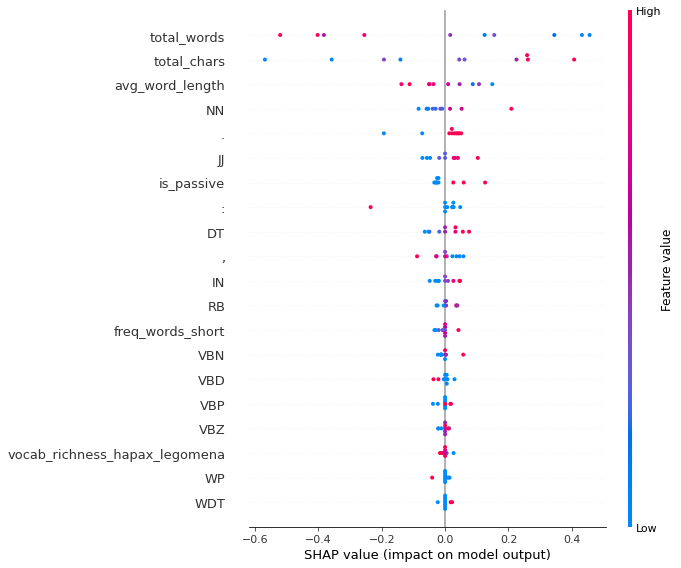

In [28]:
# export summary plot
shap.summary_plot(svm_shap_values, X_sample, show=True)

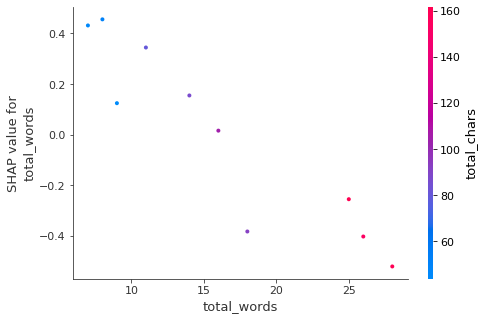

In [29]:
shap.dependence_plot("total_words", svm_shap_values, X_sample)

## SVM 4: Without total_ values. (POS are absolute)

- f1: 81%
- f1 tuned: 83%

In [ ]:
# normalize pos tags and num_punctuation for SVM model
#df[list(pos_tags) + ["num_punctuation"]] = df[list(pos_tags) + ["num_punctuation"]].div(df.num_words, axis=0)

In [30]:
total_values = [c for c in list(df_v2.columns) if c.startswith("total_")]
total_values

['total_chars', 'total_words']

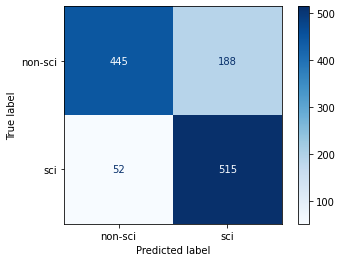

In [31]:
exclude_from_training = ["sentence", "scientific"] + total_values

X = df_v2.drop(exclude_from_training, axis=1)
y = df_v2['scientific']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
plot_confusion_matrix(clf_svm,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [32]:
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.90      0.70      0.79       633
         sci       0.73      0.91      0.81       567

    accuracy                           0.80      1200
   macro avg       0.81      0.81      0.80      1200
weighted avg       0.82      0.80      0.80      1200



### Hyperparameter tuning

In [33]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.01)


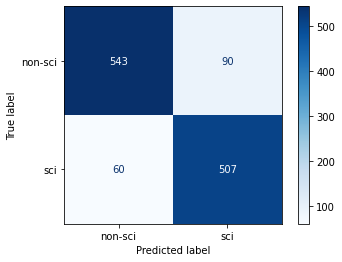

In [34]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
  
plot_confusion_matrix(grid,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [35]:
# print classification report
print(classification_report(y_test, grid_predictions, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.90      0.86      0.88       633
         sci       0.85      0.89      0.87       567

    accuracy                           0.88      1200
   macro avg       0.87      0.88      0.87      1200
weighted avg       0.88      0.88      0.88      1200



### Validation with student reports

In [36]:
# to allow for repeated execution
try:
    val_pred = grid.predict(df_val.drop(exclude_from_training + ["pred_sci"], axis=1))
except ValueError as error:
    val_pred = grid.predict(df_val.drop(["sentence"], axis=1))

df_val['scientific'] = 0
df_val['pred_sci'] = val_pred

print(classification_report(df_val['scientific'],df_val['pred_sci'], target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       1.00      0.76      0.86      4389
         sci       0.00      0.00      0.00         0

    accuracy                           0.76      4389
   macro avg       0.50      0.38      0.43      4389
weighted avg       1.00      0.76      0.86      4389



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

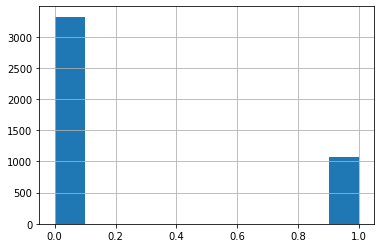

In [37]:
df_val.pred_sci.hist()

Much better. Majority is considered as non-scientific.

### Validation with scientific sentences from latest tf cleaned

In [38]:
# load sci dataset
sent_tf_cleaned_val = pickle.load(open(os.path.join(FOLDER_TF_SCI, "filtered_sent_cola.pkl"), "rb"))
print(f"{len(sent_tf_cleaned_val)} - original size")

# remove sentences that were used for training & testing SVM
sent_tf_cleaned_val = [s for s in sent_tf_cleaned_val if s not in sent_tf_cleaned]
print(f"{len(sent_tf_cleaned_val)} - size after filtering")

# randomize them
random.shuffle(sent_tf_cleaned_val)

105056 - original size
102056 - size after filtering


In [39]:
# extract features
df_val_sci = pd.DataFrame(data=sent_tf_cleaned_val[:5000], columns=["sentence"])
(df_val_sci, columns_val_sci) = add_features(df_val_sci)

lexical features character based
lexical features word based


  0%|          | 0/5000 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/5000 [00:00<?, ?it/s]

In [40]:
# to allow for repeated execution
try:
    val_pred_sci = grid.predict(df_val_sci.drop(exclude_from_training + ["pred_sci"], axis=1))
except KeyError as error:
    val_pred_sci = grid.predict(df_val_sci.drop([c for c in exclude_from_training if c != "scientific"], axis=1))

df_val_sci['scientific'] = 1
df_val_sci['pred_sci'] = val_pred_sci

print(classification_report(df_val_sci['scientific'],df_val_sci['pred_sci'], target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.00      0.00      0.00         0
         sci       1.00      0.90      0.95      5000

    accuracy                           0.90      5000
   macro avg       0.50      0.45      0.47      5000
weighted avg       1.00      0.90      0.95      5000



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

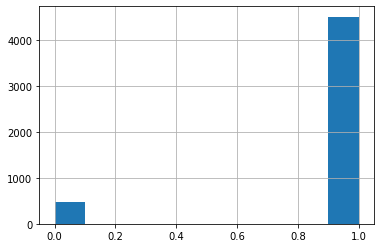

In [41]:
df_val_sci.pred_sci.hist()

perfect

### SHAP insights

Now we can have a look into which features are most important.

In [42]:
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
import shap

# The SHAP values
X_sample = shap.sample(X, nsamples=10, random_state=0)

svm_explainer = shap.KernelExplainer(grid.predict,X_sample)
svm_shap_values = svm_explainer.shap_values(X_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

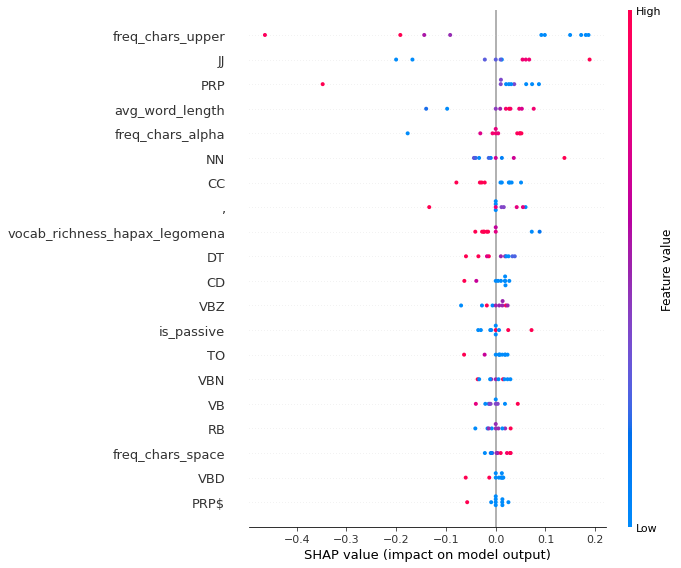

In [43]:
# export summary plot
shap.summary_plot(svm_shap_values, X_sample, show=True)

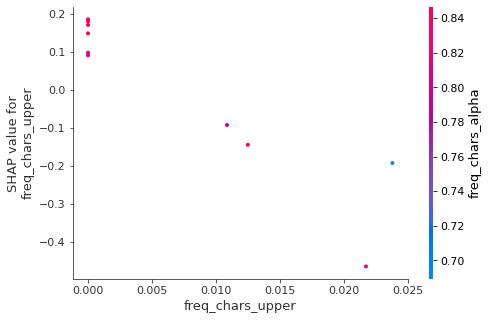

In [45]:
shap.dependence_plot("freq_chars_upper", svm_shap_values, X_sample)

## SVM 5: freq. measures only (best results for validation)

Removing the total & avg. values above was good for the model. Let's see, if turning all values to frequencies [0,1] and doing further feature selection yields even better results:

- f1: 82%
- f1 tuned: 85%

In [46]:
# before
df_v2.head(1)

,sentence,scientific,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive
0,Important questions to answer include:,0,38,0.868421,0.026316,0.0,0.105263,0.026316,5,0.2,6.6,1.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# (1) normalize pos tags for SVM model
df_v2_freq = df_v2.copy()
df_v2_freq[columns_v2['cols_pos_tag']] = df_v2_freq[columns_v2['cols_pos_tag']].div(df_v2_freq.total_words, axis=0)

df_v2_freq.head(2)

,sentence,scientific,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive
0,Important questions to answer include:,0,38,0.868421,0.026316,0.000000,0.105263,0.026316,5,0.2,6.600000,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.2,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.200000,0.0,0.0,0.0,0.0,0.200000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,"For regression algorithms, the three most popular metrics are MAE, MSE and the R²-score.",0,88,0.795455,0.090909,0.011364,0.147727,0.045455,14,0.5,5.142857,0.928571,0.857143,0.076923,0.0,0.0,0.0,0.0,0.142857,0.0,0.071429,0.0,0.071429,0.071429,0.142857,0.0,0.0,0.071429,0.071429,0.0,0.0,0.0,0.0,0.142857,0.214286,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [48]:
# (2) columns to be excluded: total and average values
total_values = [c for c in list(df_v2_freq.columns) if c.startswith("total_")]
total_values += [c for c in list(df_v2_freq.columns) if c.startswith("avg_")]
total_values

['total_chars', 'total_words', 'avg_word_length']

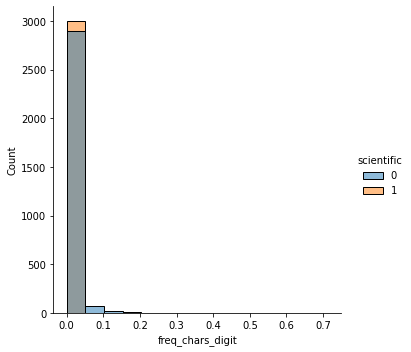

In [64]:
# (3) further feature selection
# all scientific sentences are lowercase
sns.displot(x=df_v2_freq.freq_chars_upper, hue=df_v2_freq.scientific)
exclude_further = ["freq_chars_upper"]

In [50]:
# (3) further feature selection
# non_scientific sentences are less cleaned and result in having a much lower freq_chars_alpha value
#sns.displot(x=df_v2_freq.freq_chars_alpha, hue=df_v2_freq.scientific)
exclude_further += ["freq_chars_alpha"]
df_v2_freq[df_v2_freq.scientific == 0][["sentence", "freq_chars_alpha"]].sort_values(by='freq_chars_alpha', ascending=True)

,sentence,freq_chars_alpha
1980,"193{203, 1999.",0.000000
2063,= 0.272 / 0.456 = 0.596,0.000000
2999,"6848–6856, doi: 10.1109/CVPR.2018.00716.",0.175000
649,Hₐ: μ = 2.67,0.250000
2024,arXiv:1909.06312 [cs.LG] (2019),0.290323
...,...,...
629,Excessive model complexity causes overfitting.,0.891304
2933,Install Google Assistant API,0.892857
1601,Important Side Note,0.894737
525,Photography Splash Page,0.913043


In [65]:
# removing all char frequencies, because the latest cleaned dataset was stripped off of all of them
exclude_further += [c for c in list(df_v2_freq.columns) if c.startswith("freq_chars_")]
exclude_further

['freq_chars_upper',
 'freq_chars_alpha',
 'freq_chars_upper',
 'freq_chars_digit',
 'freq_chars_space',
 'freq_chars_special']

training X: ['freq_words_short', 'freq_unique_words', 'vocab_richness_hapax_legomena', 'vocab_richness_hapax_dislegomena', '$', "''", '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', '#', 'is_passive']

training y: scientific

excluded: ['sentence', 'scientific', 'total_chars', 'total_words', 'avg_word_length', 'freq_chars_upper', 'freq_chars_alpha', 'freq_chars_upper', 'freq_chars_digit', 'freq_chars_space', 'freq_chars_special']


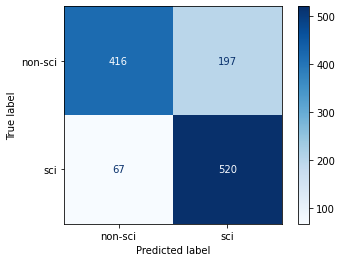

In [66]:
exclude_from_training = ["sentence", "scientific"] + total_values + exclude_further

X = df_v2_freq.drop(exclude_from_training, axis=1)
y = df_v2_freq['scientific']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
plot_confusion_matrix(clf_svm,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

print(f"training X: {list(X.columns)}\n")
print(f"training y: {y.name}\n")

print(f"excluded: {exclude_from_training}")

In [67]:
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.86      0.68      0.76       613
         sci       0.73      0.89      0.80       587

    accuracy                           0.78      1200
   macro avg       0.79      0.78      0.78      1200
weighted avg       0.79      0.78      0.78      1200



### Hyperparameter tuning

In [68]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.1)


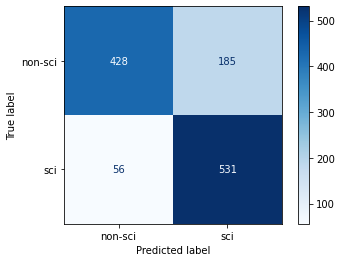

In [69]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
  
plot_confusion_matrix(grid,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [70]:
# print classification report
print(classification_report(y_test, grid_predictions, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.88      0.70      0.78       613
         sci       0.74      0.90      0.82       587

    accuracy                           0.80      1200
   macro avg       0.81      0.80      0.80      1200
weighted avg       0.81      0.80      0.80      1200



### Validation with student reports

In [71]:
# to allow for repeated execution

df_val_freq = df_val.copy()
df_val_freq[columns_v2['cols_pos_tag']] = df_val_freq[columns_v2['cols_pos_tag']].div(df_val_freq.total_words, axis=0)

try:
    val_pred = grid.predict(df_val_freq.drop(exclude_from_training + ["pred_sci"], axis=1))
except ValueError as error:
    val_pred = grid.predict(df_val_freq.drop(exclude_from_training, axis=1))

df_val_freq['scientific'] = 0
df_val_freq['pred_sci'] = val_pred

try:
    print(classification_report(df_val_freq['scientific'],df_val_freq['pred_sci'], target_names=["non-sci", "sci"]))
except ValueError:
    print(classification_report(df_val_freq['scientific'],df_val_freq['pred_sci'], target_names=["non-sci"]))

              precision    recall  f1-score   support

     non-sci       1.00      0.54      0.70      4389
         sci       0.00      0.00      0.00         0

    accuracy                           0.54      4389
   macro avg       0.50      0.27      0.35      4389
weighted avg       1.00      0.54      0.70      4389



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

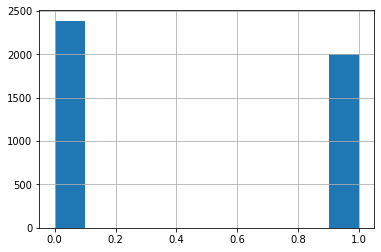

In [72]:
df_val_freq.pred_sci.hist()

Much better. Majority is considered as non-scientific.

### Validation with scientific sentences from latest tf cleaned

In [73]:
df_val_sci.head(3)

,sentence,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive,scientific,pred_sci
0,the construction of the final knowledge representation structures is done as follows.,85,0.858824,0.0,0.0,0.129412,0.011765,12,0.416667,6.083333,0.916667,0.833333,0.090909,0,0,0,0,0,0,1,0,0,0,2,0,0,2,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,1,1,1
1,"the denser the triangles are, the closer the node is to the core of the community.",82,0.792683,0.0,0.0,0.182927,0.024390,16,0.625000,4.062500,0.687500,0.625000,0.000000,0,0,0,0,1,0,1,0,0,0,6,0,0,1,0,1,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1
2,the first step is to perturb the previous transcription to make a new one.,74,0.810811,0.0,0.0,0.175676,0.013514,14,0.571429,4.285714,0.857143,0.714286,0.166667,0,0,0,0,0,0,1,0,0,1,3,0,0,0,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [74]:
# to allow for repeated execution

df_val_sci_freq = df_val_sci.copy()
df_val_sci_freq[columns_v2['cols_pos_tag']] = df_val_sci_freq[columns_v2['cols_pos_tag']].div(df_val_sci_freq.total_words, axis=0)

try:
    val_pred_sci = grid.predict(df_val_sci_freq.drop(exclude_from_training + ["pred_sci"], axis=1))
except KeyError as error:
    val_pred_sci = grid.predict(df_val_sci_freq.drop([c for c in exclude_from_training if c != "scientific"], axis=1))

df_val_sci_freq['scientific'] = 1
df_val_sci_freq['pred_sci'] = val_pred_sci


print(classification_report(df_val_sci_freq['scientific'],df_val_sci_freq['pred_sci'], target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.00      0.00      0.00         0
         sci       1.00      0.92      0.96      5000

    accuracy                           0.92      5000
   macro avg       0.50      0.46      0.48      5000
weighted avg       1.00      0.92      0.96      5000



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

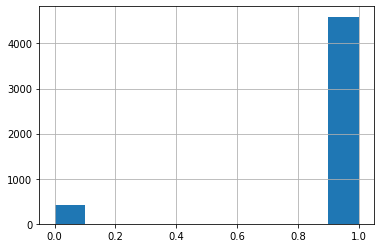

In [75]:
df_val_sci_freq.pred_sci.hist()

perfect

### SHAP insights

Now we can have a look into which features are most important.

In [76]:
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
import shap

# The SHAP values
X_sample = shap.sample(X, nsamples=10, random_state=0)

svm_explainer = shap.KernelExplainer(grid.predict,X_sample)
svm_shap_values = svm_explainer.shap_values(X_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

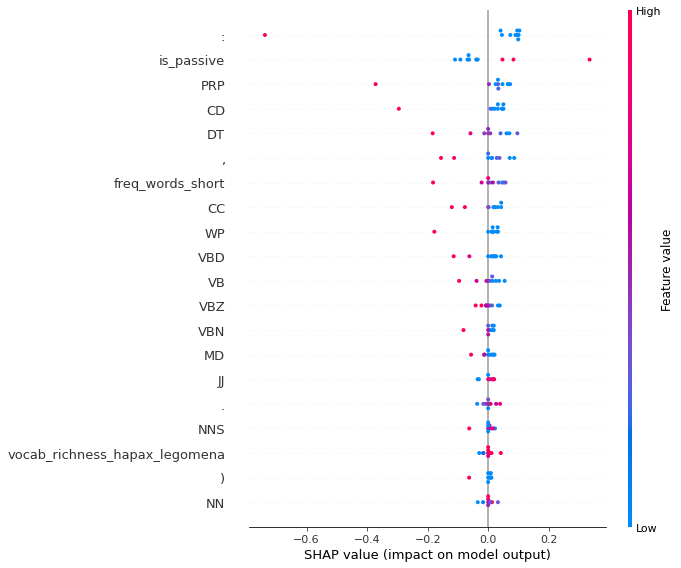

In [77]:
# export summary plot
shap.summary_plot(svm_shap_values, X_sample, show=True)

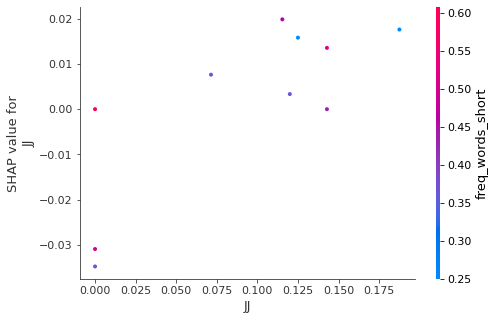

In [78]:
shap.dependence_plot("JJ", svm_shap_values, X_sample)

## SVM 6: char trigrams

In [100]:
def add_features_trigrams(df):
    columns = {}

    print("char trigrams")
    (cols_trigram, df_sub) = TextFeatures.extract_char_trigrams(df["sentence"])
    df[cols_trigram] = df_sub[cols_trigram]
    columns["char_trigrams"] = cols_trigram
    
    return (df, columns)

In [90]:
df_v2_freq_full = df_v2_freq.copy()
(df_v2_freq_full, df_v2_freq_full_colls) = add_features_trigrams(df_v2_freq_full)

char trigrams


  0%|          | 0/6000 [00:00<?, ?it/s]

In [91]:
df_v2_freq_full.shape

(6000, 311)

In [101]:
df_v2_freq_full.head(2)

,sentence,scientific,total_chars,freq_chars_alpha,freq_chars_upper,freq_chars_digit,freq_chars_space,freq_chars_special,total_words,freq_words_short,avg_word_length,freq_unique_words,vocab_richness_hapax_legomena,vocab_richness_hapax_dislegomena,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``,#,is_passive,/ a /,/ al/,/ an/,/ ar/,/ as/,/ be/,/ ca/,/ co/,/ da/,/ de/,/ di/,/ do/,/ ex/,/ fi/,/ fo/,/ fr/,/ ha/,/ im/,/ in/,/ is/,/ it/,/ le/,/ li/,/ lo/,/ ma/,/ me/,/ mo/,/ ne/,/ no/,/ of/,/ on/,/ pa/,/ po/,/ pr/,/ re/,/ se/,/ si/,/ so/,/ st/,/ su/,/ th/,/ to/,/ tr/,/ us/,/ we/,/ wh/,/ wi/,/ wo/,/ yo/,"/, a/","/, t/","/, w/",/a s/,/abl/,/ach/,/act/,/age/,/ain/,/al /,/all/,/an /,/and/,/app/,/are/,/art/,/as /,/ase/,/at /,/ata/,/ate/,/ati/,/ave/,/be /,/ble/,/by /,/cal/,/can/,/ce /,/ces/,/ch /,/com/,/con/,/cti/,/d a/,/d b/,/d i/,/d t/,/dat/,/der/,/e a/,/e b/,/e c/,/e d/,/e e/,/e f/,/e i/,/e l/,/e m/,/e n/,/e o/,/e p/,/e r/,/e s/,/e t/,/e w/,"/e, /",/ear/,/ect/,/ed /,/en /,/enc/,/ent/,/er /,/era/,/ere/,/ers/,/es /,/ese/,/ess/,/est/,/eve/,/f t/,/for/,/g t/,/hat/,/hav/,/he /,/her/,/his/,/how/,/ica/,/ide/,/ill/,/imp/,/in /,/ine/,/ing/,/int/,/ion/,/is /,/ist/,/it /,/ith/,/iti/,/ity/,/ive/,/lat/,/le /,/ll /,/ly /,/mat/,/me /,/men/,/mod/,/mpl/,/n a/,/n i/,/n o/,/n t/,/nal/,/nce/,/nd /,/ne /,/ng /,/not/,/ns /,/nt /,/nte/,/nti/,/o t/,/ode/,/of /,/om /,/omp/,/on /,/one/,/ons/,/or /,/ore/,/orm/,/ot /,/ou /,/our/,/ove/,/ow /,/par/,/per/,/ple/,/pre/,/pro/,/r a/,/r t/,/rat/,/re /,/rea/,/red/,/res/,/rs /,/ry /,/s a/,/s c/,/s f/,/s i/,/s o/,/s s/,/s t/,/s w/,"/s, /",/se /,/sed/,/sin/,/st /,/sta/,/ste/,/sti/,/str/,/t a/,/t i/,/t o/,/t t/,/tat/,/te /,/ted/,/ter/,/th /,/tha/,/the/,/thi/,/tic/,/tim/,/tin/,/tio/,/tiv/,/to /,/tra/,/tri/,/ts /,/tur/,/ty /,/ur /,/ure/,/use/,/ut /,/ve /,/ver/,/we /,/wit/,/wor/,/y t/,/you/
0,Important questions to answer include:,0,38,0.868421,0.026316,0.000000,0.105263,0.026316,5,0.2,6.600000,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.2,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.200000,0.0,0.0,0.0,0.0,0.200000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000,0.206416,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198306,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.201999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.236995,0.0,0.0,0.0,0.0,0.0,0.000000,0.341855,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.365176,0.0,0.0,0.0,0.0,0.191919,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.321529,0.281711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.27585,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.248275,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.36236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.201042,0.0,0.204565,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"For regression algorithms, the three most popular metrics are MAE, MSE and the R²-score.",0,88,0.795455,0.090909,0.011364,0.147727,0.045455,14,0.5,5.142857,0.928571,0.857143,0.076923,0.0,0.0,0.0,0.0,0.142857,0.0,0.071429,0.0,0.071429,0.071429,0.142857,0.0,0.0,0.071429,0.071429,0.0,0.0,0.0,0.0,0.142857,0.214286,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.163114,0.112855,0.157899,0.0,0

In [137]:
# add another exclusion
exclude_further += ":"

training X: ['freq_words_short', 'freq_unique_words', 'vocab_richness_hapax_legomena', 'vocab_richness_hapax_dislegomena', '$', "''", '(', ')', ',', '--', '.', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', '#', 'is_passive', '/ a /', '/ al/', '/ an/', '/ ar/', '/ as/', '/ be/', '/ ca/', '/ co/', '/ da/', '/ de/', '/ di/', '/ do/', '/ ex/', '/ fi/', '/ fo/', '/ fr/', '/ ha/', '/ im/', '/ in/', '/ is/', '/ it/', '/ le/', '/ li/', '/ lo/', '/ ma/', '/ me/', '/ mo/', '/ ne/', '/ no/', '/ of/', '/ on/', '/ pa/', '/ po/', '/ pr/', '/ re/', '/ se/', '/ si/', '/ so/', '/ st/', '/ su/', '/ th/', '/ to/', '/ tr/', '/ us/', '/ we/', '/ wh/', '/ wi/', '/ wo/', '/ yo/', '/, a/', '/, t/', '/, w/', '/a s/', '/abl/', '/ach/', '/act/', '/age/', '/ain/', '/al /', '/all/', '/an /', '/and/', '/app/', '/are/', '

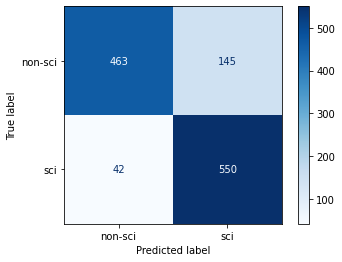

In [138]:
exclude_from_training = ["sentence", "scientific"] + total_values + exclude_further

X = df_v2_freq_full.drop(exclude_from_training, axis=1)
y = df_v2_freq_full['scientific']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)


y_pred = clf_svm.predict(X_test)
plot_confusion_matrix(clf_svm,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

print(f"training X: {list(X.columns)}\n")
print(f"training y: {y.name}\n")

print(f"excluded: {exclude_from_training}")

In [139]:
print(classification_report(y_test,y_pred, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.92      0.76      0.83       608
         sci       0.79      0.93      0.85       592

    accuracy                           0.84      1200
   macro avg       0.85      0.85      0.84      1200
weighted avg       0.85      0.84      0.84      1200



### Hyperparameter tuning

In [140]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 2, n_jobs=2)
# n_jobs=2, verbose = 2
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.01)


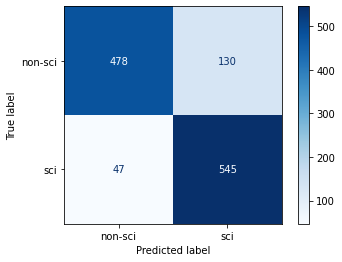

In [141]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
  
plot_confusion_matrix(grid,
                             X_test,
                             y_test,
                             display_labels=["non-sci", "sci"],
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )

In [107]:
# print classification report
print(classification_report(y_test, grid_predictions, target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.86      0.78      0.82       596
         sci       0.80      0.87      0.83       604

    accuracy                           0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.83      0.83      1200



### Validation with student reports

In [117]:
df_val_freq_full = df_val_freq.copy()
(df_val_freq_full, df_val_freq_full_colls) = add_features_trigrams(df_val_freq_full)

char trigrams


  0%|          | 0/4389 [00:00<?, ?it/s]

In [142]:
df_val_freq_full.shape

(4389, 312)

In [143]:
# to allow for repeated execution
try:
    val_pred = grid.predict(df_val_freq_full.drop(exclude_from_training + ["pred_sci"], axis=1))
except ValueError as error:
    val_pred = grid.predict(df_val_freq_full.drop(exclude_from_training, axis=1))

df_val_freq_full['scientific'] = 0
df_val_freq_full['pred_sci'] = val_pred

try:
    print(classification_report(df_val_freq_full['scientific'],df_val_freq_full['pred_sci'], target_names=["non-sci", "sci"]))
except ValueError:
    print(classification_report(df_val_freq_full['scientific'],df_val_freq_full['pred_sci'], target_names=["non-sci"]))

              precision    recall  f1-score   support

     non-sci       1.00      0.63      0.77      4389
         sci       0.00      0.00      0.00         0

    accuracy                           0.63      4389
   macro avg       0.50      0.31      0.39      4389
weighted avg       1.00      0.63      0.77      4389



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

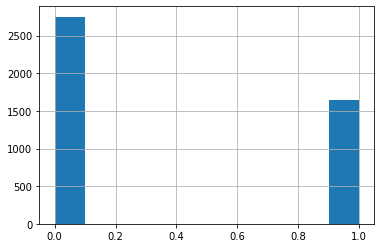

In [144]:
df_val_freq_full.pred_sci.hist()

Much better. Majority is considered as non-scientific.

### Validation with scientific sentences from latest tf cleaned

In [127]:
df_val_sci_freq_full = df_val_sci_freq.copy()
(df_val_sci_freq_full, df_val_sci_full_colls) = add_features_trigrams(df_val_sci_freq_full)

char trigrams


  0%|          | 0/5000 [00:00<?, ?it/s]

In [145]:
df_val_sci_freq_full.shape

(5000, 312)

In [146]:
# to allow for repeated execution

try:
    val_pred_sci = grid.predict(df_val_sci_freq_full.drop(exclude_from_training + ["pred_sci"], axis=1))
except KeyError as error:
    val_pred_sci = grid.predict(df_val_sci_freq_full.drop([c for c in exclude_from_training if c != "scientific"], axis=1))

df_val_sci_freq_full['scientific'] = 1
df_val_sci_freq_full['pred_sci'] = val_pred_sci


print(classification_report(df_val_sci_freq_full['scientific'],df_val_sci_freq_full['pred_sci'], target_names=["non-sci", "sci"]))

              precision    recall  f1-score   support

     non-sci       0.00      0.00      0.00         0
         sci       1.00      0.66      0.80      5000

    accuracy                           0.66      5000
   macro avg       0.50      0.33      0.40      5000
weighted avg       1.00      0.66      0.80      5000



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

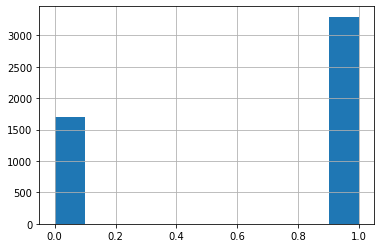

In [147]:
df_val_sci_freq_full.pred_sci.hist()

perfect

### SHAP insights

Now we can have a look into which features are most important.

In [148]:
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
import shap

# The SHAP values
X_sample = shap.sample(X, nsamples=15, random_state=0)

svm_explainer = shap.KernelExplainer(grid.predict,X_sample)
svm_shap_values = svm_explainer.shap_values(X_sample)

  0%|          | 0/15 [00:00<?, ?it/s]

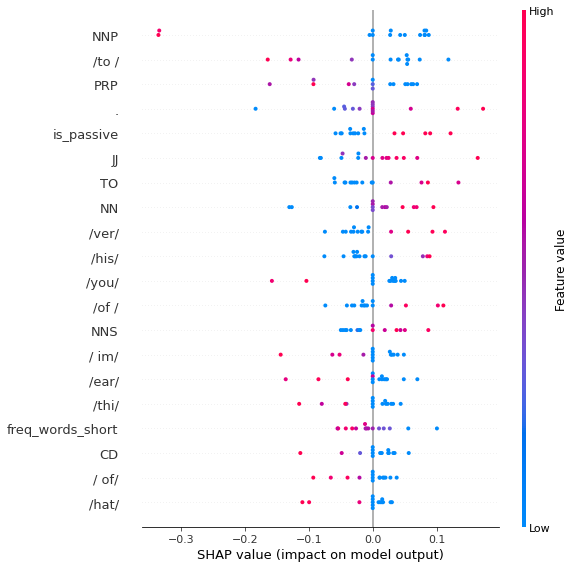

In [149]:
# export summary plot
shap.summary_plot(svm_shap_values, X_sample, show=True)

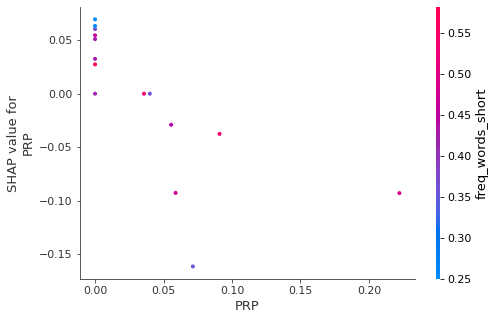

In [152]:
shap.dependence_plot("PRP", svm_shap_values, X_sample)

# conclusion

- Done. The final model SVM 6 is good enough.
- This jupyter notebook gets too large. Hence, creating another one for the final evaluation.